In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

Feature vectors are composed of simple summaries of the documents. 

In [5]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

In [6]:
df.sample(10)

,index,label,text
21998,1998,spam,"In fact, I use Spelt flour for everything! It ..."
22940,2940,spam,"They're not too sweet, nor too sour and the af..."
26601,6601,spam,Don't be fooled into thinking you are paying f...
4500,4500,legitimate,Lady Bertram could not give it a thought. But ...
7878,7878,legitimate,Not that _she_ was incommoded by many fears of...
21180,1180,spam,"This 2-tier, 18-cup design in black is a good ..."
4863,4863,legitimate,I'm definitely sold on this product so I bough...
18514,18514,legitimate,"Seriously, sprinkles are not just to Harriet's..."
16932,16932,legitimate,"Fanny was very thankful. She read, and was sur..."
19380,19380,legitimate,Elizabeth impatiently caught it from his hand....


In [7]:
#note level and index coincide for the legitimate documents, but not for the spam - 
    #for spam, index = level_0 mod 20,000
df.reset_index(inplace=True) 

In [8]:
df.sample(10)

,level_0,index,label,text
23122,23122,3122,spam,"Dog is happy as well and in perfect condition,..."
27037,27037,7037,spam,"He is learning to like more foods, other than ..."
31078,31078,11078,spam,"They taste better than home-made, with a hint ..."
26772,26772,6772,spam,Tree was advertised as a pack of 24 in the nea...
33016,33016,13016,spam,I got these for them all the time but not anym...
24341,24341,4341,spam,He would not go out of my way to find. Nice th...
4839,4839,4839,legitimate,"To the little town of Lambton, the scene of ag..."
24710,24710,4710,spam,"Serving per serving, it is very pleasant and i..."
7108,7108,7108,legitimate,"Before they were beyond her hearing, however, ..."
37350,37350,17350,spam,"Once you eaten them, no other pretzel compares..."


We can now "explode" the text into words, so that each word occupies a row of the data frame, and retains the associated "level_0", "index" and "label". 

In [9]:
rows = []
_ = df.apply(lambda row: [rows.append([row['level_0'], row['index'], row['label'], word]) 
                         for word in row.text.split()], axis=1)

In [10]:
rows[1:10]

[[0, 0, 'legitimate', 'must'],
 [0, 0, 'legitimate', 'write'],
 [0, 0, 'legitimate', 'to'],
 [0, 0, 'legitimate', 'me.'],
 [0, 0, 'legitimate', 'Catherine'],
 [0, 0, 'legitimate', 'sighed.'],
 [0, 0, 'legitimate', 'And'],
 [0, 0, 'legitimate', 'there'],
 [0, 0, 'legitimate', 'are']]

In [11]:
df_explode = pd.DataFrame(rows, columns=df.columns)
df_explode

,level_0,index,label,text
0,0,0,legitimate,You
1,0,0,legitimate,must
2,0,0,legitimate,write
3,0,0,legitimate,to
4,0,0,legitimate,me.
5,0,0,legitimate,Catherine
6,0,0,legitimate,sighed.
7,0,0,legitimate,And
8,0,0,legitimate,there
9,0,0,legitimate,are


Column "level_0" contains the index we want to aggregate any calculations over. 

The summmaries we are going to compute for each document (indexed by "level_0") are: 
    number of words in each document
    average word length
    maximum word length
    minimum word length
    10th percentile word length
    90th percentile word length
    number of upper case words
    
    
Many of these require the word length to be computed. To save us from recomputing this every time, we will begin add a column containing this information to our 'exploded' data frame. 


In [12]:
df_explode["word_len"] = df_explode["text"].apply(len) 

In [13]:
df_explode.sample(10) ## looks fine, though punctuation is being counted as a character in this word length calculation. 

,level_0,index,label,text,word_len
948469,10550,10550,legitimate,represent,9
893922,9951,9951,legitimate,soon,4
1553275,17262,17262,legitimate,did,3
667702,7455,7455,legitimate,into,4
1603858,17830,17830,legitimate,been,4
1262846,14027,14027,legitimate,was,3
2874387,33502,13502,spam,been,4
3042968,35596,15596,spam,all,3
367952,4120,4120,legitimate,while,5
35844,403,403,legitimate,hearing,7


We will record the summaries for each document in a new data frame called summaries. We start by computing the number of words in each document. 

In [14]:
counts = df_explode['level_0'].value_counts()

df_summaries = pd.DataFrame({'counts' :counts})

In [15]:
df_summaries.sample(10)

,counts
11717,46
22837,141
1160,112
34816,102
1561,69
6447,69
29965,71
33384,64
812,146
15324,84


In [16]:
df_summaries["av_wl"] = df_explode.groupby('level_0')['word_len'].mean() #average word length


In [17]:
df_summaries.sample(10)

,counts,av_wl
30363,104,4.201923
27131,71,4.521127
10875,81,4.703704
36819,153,4.705882
39855,123,4.341463
10248,51,4.294118
16876,91,4.428571
23697,56,4.625000
19421,65,4.892308
35439,42,4.023810


In [18]:
df_summaries["max_wl"] = df_explode.groupby('level_0')['word_len'].max() #max word length
df_summaries["min_wl"] = df_explode.groupby('level_0')['word_len'].min() #min word length

In [19]:
df_summaries["10_quantile"] = df_explode.groupby('level_0')['word_len'].quantile(0.1) #average word length

In [20]:
df_summaries["90 quantile"]= df_explode.groupby('level_0')['word_len'].quantile(0.9)

In [65]:
#item.islower returns true if all are lowercase, else false.
#so this is capturing words with capital letters anywhere in them, not just at the start. 
#note: isupper only returns true if all characters are upper case. 
def caps(word):
    return not word.islower()
df_explode["upper_case"]=df_explode['text'].apply(caps)

df_summaries["upper_case"] = df_explode.groupby('level_0')['upper_case'].sum() 

In [66]:
df_summaries.sample(10)

,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case
6088,60,4.100000,11,1,2.0,8.0,9.0
34421,130,4.315385,11,1,2.0,8.0,19.0
37179,83,4.265060,11,1,2.0,7.0,18.0
31762,43,4.116279,10,1,2.0,7.0,7.0
28088,80,4.400000,14,1,2.0,8.0,8.0
23185,119,4.226891,12,1,2.0,7.0,17.0
22857,50,4.200000,9,1,2.0,7.1,7.0
24872,51,4.372549,12,1,2.0,8.0,9.0
14134,37,4.918919,11,2,2.6,8.0,5.0
34485,60,4.383333,12,1,2.0,7.1,10.0


As well as the simple summaries relating to word length, we can compute some more involved summaries related to language. 

In [67]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [68]:
def isstopword(word):
    return word in ENGLISH_STOP_WORDS

df_explode["stop_words"]=df_explode['text'].apply(isstopword)

In [69]:
df_summaries["stop_words"] = df_explode.groupby('level_0')['stop_words'].sum() 

In [70]:
df_summaries.sample(11)

,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case,stop_words
7138,106,4.141509,12,1,2.0,7.0,13.0,56.0
9199,47,4.574468,15,1,2.0,7.8,12.0,22.0
19181,99,4.363636,12,1,2.0,8.0,14.0,49.0
26116,91,4.197802,9,1,2.0,7.0,13.0,38.0
13369,52,4.673077,15,1,2.0,8.9,7.0,27.0
30796,96,4.302083,12,1,2.0,7.0,12.0,48.0
6142,45,3.977778,10,1,2.0,7.6,10.0,21.0
10652,236,4.351695,12,1,2.0,7.0,18.0,123.0
448,77,4.649351,11,2,2.0,8.0,9.0,44.0
13360,86,4.500000,10,1,2.0,9.0,9.0,45.0


In [71]:
import string
import regex as re
def punct_count(doc):
    print(doc)
    return sum(string.punctuation in doc)     

def punct_count2(doc):
    return sum(bool(re.match(r"""[!.><:;'@#~{}\[\]-_+=£$%^&()?]""", c)) for c in doc)



In [72]:
df_explode["punct"]=df_explode['text'].apply(punct_count2)

df_summaries["punctuation"]=df['text'].apply(punct_count2)
df_summaries["punct"]=df_explode.groupby('level_0')['punct'].sum() 


In [73]:
df_summaries.sample(10)

,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case,stop_words,punctuation,punct
10325,103,3.902913,9,1,2.0,7.0,17.0,51.0,12,12
35420,120,4.741667,13,1,2.0,8.0,11.0,58.0,12,12
12311,55,4.109091,13,1,2.0,7.0,9.0,28.0,5,5
18975,71,4.577465,12,1,2.0,8.0,10.0,32.0,7,7
32087,46,3.956522,11,1,2.0,6.0,5.0,21.0,8,8
34525,64,4.531250,12,1,2.0,8.7,7.0,28.0,8,8
19044,72,4.694444,15,1,2.0,8.0,10.0,31.0,9,9
24170,75,4.573333,14,1,2.0,8.0,14.0,34.0,12,12
35341,21,5.380952,11,1,2.0,9.0,3.0,6.0,4,4
7511,139,4.057554,11,1,2.0,7.0,20.0,72.0,14,14


In [77]:
import sklearn.decomposition

DIMENSIONS = 2

pca = sklearn.decomposition.PCA(DIMENSIONS)

pca_summaries = pca.fit_transform(df_summaries)

In [78]:
pca_summaries

array([[252.15526196,  -7.83886366],
       [250.10113016,  -6.87989753],
       [220.06744688, -11.01269483],
       ...,
       [-93.2137788 ,  -3.23264207],
       [-94.17609803,  -3.64386253],
       [-94.07760052,  -3.39714297]])

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


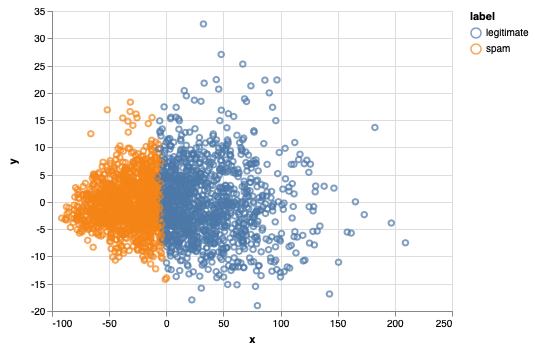

In [81]:
pca_summaries_plot_data = pd.concat([df, pd.DataFrame(pca_summaries, columns=["x", "y"])], axis=1)

#tsne_plot_data = pd.concat([sdf.reset_index(), pd.DataFrame(tsne_a, columns=["x", "y"])], axis=1)

from mlworkflows import plot

plot.plot_points(pca_summaries_plot_data, x="x", y="y", color="label")